# Vision Transformer with TensorFlow on Amazon SageMaker

Vision Transformer is a new model to achieve SOTA in vision classification with using transformer style encoders. The demo is a sample implementation of Vision Transformer trained from scratch with TensorFlow on Amazon SageMaker.

# Set up the environment

In [ ]:
!pip install --upgrade pip -q
!pip install -U sagemaker -q

In [ ]:
import sagemaker

print(sagemaker.__version__)
session = sagemaker.Session()
role = sagemaker.get_execution_role()

# Training Data
The CIFAR-10 dataset is one of the most popular machine learning datasets. It consists of 60,000 32x32 images belonging to 10 different classes (6,000 images per class). Here are the classes in the dataset, as well as 10 random images from each:

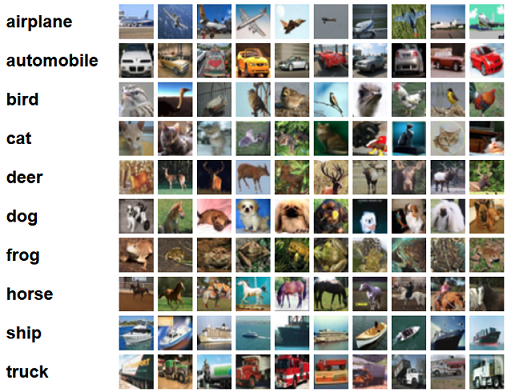

# Prepare the dataset for training
We first download the CIFAR-10 dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

Next, we upload the data to Amazon S3. We are going to use the sagemaker.Session.upload_data function to upload our datasets to an S3 location. The return value dataset_uri identifies the S3 path -- we will use later when we start the training job. This might take few minutes.

In [ ]:
import os
import numpy as np

os.makedirs("./data", exist_ok = True)

np.savez('./data/training', image=x_train, label=y_train)
np.savez('./data/testing', image=x_test, label=y_test)

dataset_uri = session.upload_data(path='data', key_prefix='cifar10-dataset')
display(dataset_uri)

# Vision Transfomer Model

Training overparameterized convolutional neural networks (CNNs) with gradient-based methods have been the de-facto method for learning good representations of images for tasks such as recognition, object detection, and segmentation. There has been a great success in this space, with deeper and wider models achieving state-of-art results.

"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" introduces the Visual Transformer, an architecture which leverages mostly standard Transformer components from the original NLP-focused "Attention is All You Need" paper but instead applies them to computer vision, specifically image recognition. Images are transformed into sequences of image patches representing "tokens," similar to word tokens in NLP. The model is trained in supervised fashion on image classification using these patch sequences as input.

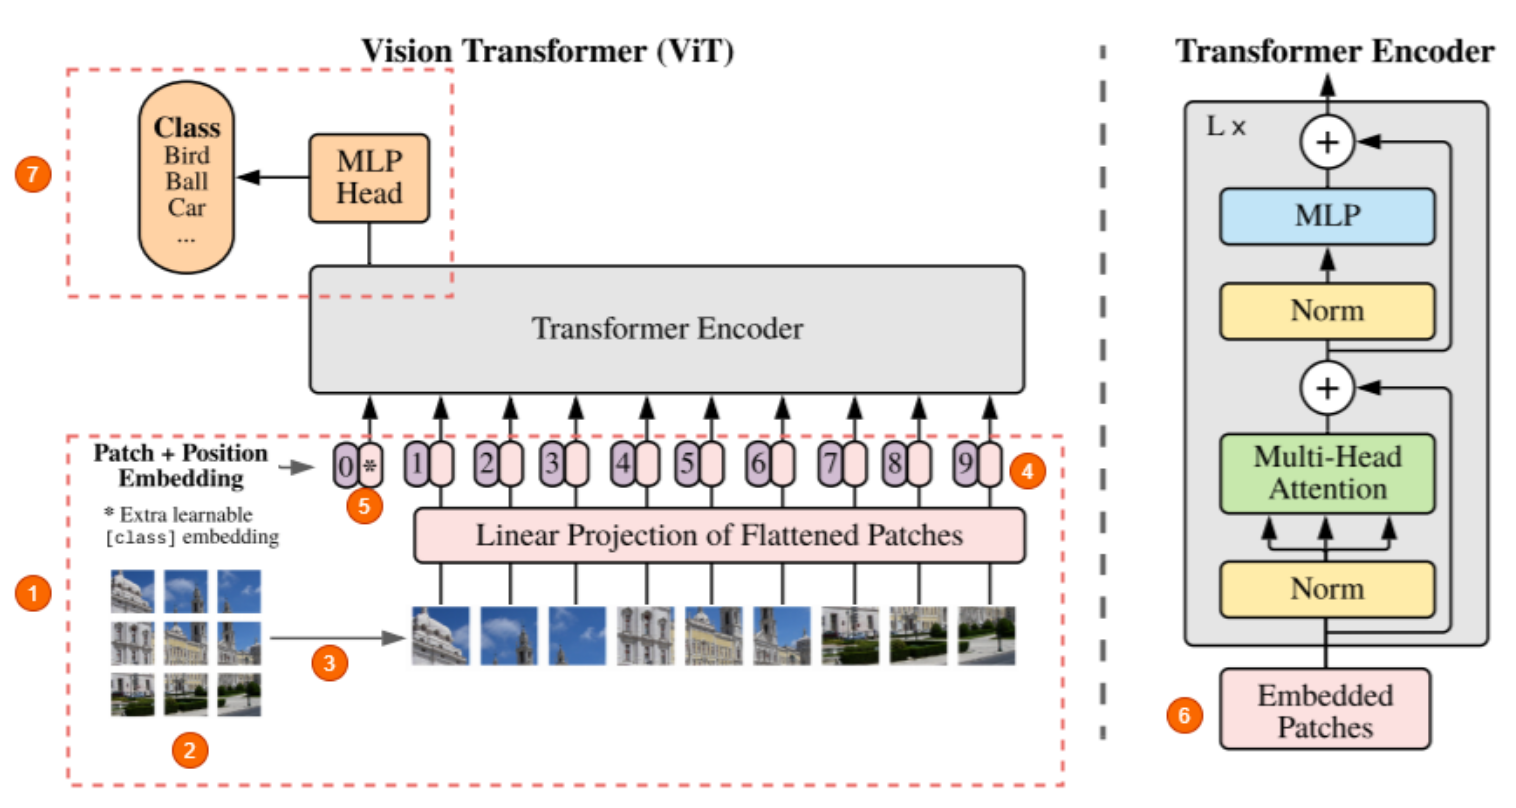

(1) They are only using the Encoder part of the transformer but the difference is in how they are feeding the images into the network.

(2) They are breaking down the image into fixed size patches. So one of these patches can be of dimension 16x16 or 32x32 as proposed in the paper. More patches means more simpler it is to train these networks as the patches themselves get smaller. Hence we have that in the title - "An Image is worth 16x16 words".

(3) The patches are then unrolled (flattened) and sent for further processing into the network.

(4) Unlike NNs here the model has no idea whatsoever about the position of the samples in the sequence, here each sample is a patch from the input image. So the image is fed along with a positional embedding vector and into the encoder. One thing to note here is the positional embeddings are also learnable so you don't actually feed hard-coded vectors w.r.t to their positions.

(5) There is also a special token at the start just like BERT.

(6) So each image patch is first unrolled (flattened) into a big vector and gets multiplied with an embedding matrix which is also learnable, creating embedded patches. And these embedded patches are combined with the positional embedding vector and that gets fed into the Tranformer.

(7) From here everything is just the same as a standard transformer. With the only difference being, instead of a decoder the output from the encoder is passed directly into a Feed Forward Neural Network to obtain the classification output.

We implement the model with TensorFlow and save as code/model.py

In [ ]:
!pygmentize 'code/model.py'

# Training Script

The train.py script provides all the code we need for training and hosting a SageMaker model. The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, including the following:

    SM_MODEL_DIR: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

    SM_NUM_GPUS: An integer representing the number of GPUs available to the host.

    SM_CHANNEL_XXX: A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the MXNet estimator’s fit call, named ‘train’ and ‘test’, the environment variables SM_CHANNEL_TRAIN and SM_CHANNEL_TEST are set.

    SM_HPS: A json dump of the hyperparameters preserving json types (boolean, integer, etc.)

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

Because the SageMaker imports the training script, you should put your training code in a main guard (if __name__=='__main__':) if you are using the same script to host your model as we do in this example, so that SageMaker does not inadvertently run your training code at the wrong point in execution.

We save this script in a file named train.py, and put the file in a directory named code/. The full training script can be viewed under code/.


In [ ]:
!pygmentize 'code/train.py'

# Train on Amazon SageMaker
We use Amazon SageMaker to train and deploy a model using our custom TensorFlow code. The Amazon SageMaker Python SDK makes it easier to run a TensorFlow script in Amazon SageMaker using its TensorFlow estimator. After that, we can use the SageMaker Python SDK to deploy the trained model and run predictions. 

To start, we use the TensorFlow estimator class to train our model. When creating our estimator, we make sure to specify a few things:

    entry_point: the name of our TensorFlow script. It contains our training script, which loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model. It also contains code to load and run the model during inference.

    source_dir: the location of our training scripts and requirements.txt file. "requirements.txt" lists packages you want to use with your script.

    framework_version: the TensorFlow version we want to use

After creating the estimator, we then call fit(), which launches a training job. We use the Amazon S3 URIs where we uploaded the training data earlier.

In [ ]:
from sagemaker.tensorflow import TensorFlow

hyperparameters = {'image-size': 32, 
                   'patch-size': 4, 
                   'num-layers': 4, 
                   'd-model': 64,
                   'num-heads': 4,
                   'mlp-dim': 128,
                   'learning-rate': 3e-4,
                   'weight-decay': 1e-4,
                   'batch-size': 256,
                   'epochs': 50
                  }

estimator = TensorFlow(
            entry_point='train.py',
            source_dir='code', # directory of your training script
            role=role,
            framework_version='2.3',
            py_version='py37',
            instance_type='ml.p3.2xlarge',
            instance_count=1,
            debugger_hook_config=False,
            hyperparameters=hyperparameters
        )
inputs = {'train': dataset_uri, 'validation': dataset_uri}
estimator.fit(inputs)

# Deploy the trained model

After we train our model, we can deploy it to a SageMaker Endpoint, which serves prediction requests in real-time. To do so, we simply call deploy() on our estimator, passing in the desired number of instances and instance type for the endpoint.

Because we’re using TensorFlow Serving for deployment, our training script saves the model in TensorFlow’s SavedModel format.

In [ ]:
from datetime import datetime

now = datetime.now()
timestr = now.strftime("%m-%d-%Y-%H-%M-%S")
ENDPOINT_NAME='tensorflow-inference-{}'.format(timestr)
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.p3.2xlarge', endpoint_name=ENDPOINT_NAME)

# Invoke the Endpoint
Let’s use the test dataset for predictions. With the data loaded, we can use it for predictions.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def predict(data):
    predictions = predictor.predict(data)['predictions']
    return predictions


predicted = []
actual = []
batches = 0
batch_size = 256

datagen = ImageDataGenerator()
for data in datagen.flow(x_test, y_test, batch_size=batch_size):
    for i, prediction in enumerate(predict(data[0].astype('uint8'))):
        predicted.append(np.argmax(prediction))
        actual.append(data[1][i][0])

    batches += 1
    if batches >= len(x_test) / batch_size:
        break

With the predictions, we calculate our model accuracy and create a confusion matrix.

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_pred=predicted, y_true=actual)
display('Average accuracy: {}%'.format(round(accuracy*100, 2)))

In [ ]:
!pip install -U matplotlib seaborn -q

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=predicted, y_true=actual)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1.4)  # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 10})  # font size

Aided by the colors of the heatmap, we can use this confusion matrix to understand how well the model performed for each label.

# Cleanup
To avoid incurring extra charges to your AWS account, let’s delete the endpoint we created.

In [ ]:
predictor.delete_endpoint()

# Thoughts
After 50 epochs, the ViT model achieves around 60%. This is not competitive results on the CIFAR-10 dataset, as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

The reason why ViT achieves inferior performance to CNNs when trained from scratch on a midsize dataset because: 1) the simple tokenization of input images fails to model the important local structure such as edges and lines among neighboring pixels, leading to low training sample efficiency; 2) the redundant attention backbone design of ViT leads to limited feature richness for fixed computation budgets and limited training samples.

Note that the state of the art results reported in the paper are achieved by pre-training the ViT model using the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality without pre-training, you can try to train the model for more epochs, use a larger number of Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameters such as the learning rate schedule, optimizer, weight decay, etc. In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset.

# References
[1] An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (https://arxiv.org/pdf/2010.11929.pdf)

[2] GitHub respsitory (https://github.com/emla2805/vision-transformer)

[3] kaggle notebook (https://www.kaggle.com/abhinand05/vision-transformer-vit-tutorial-baseline)